In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import necessary libraries
import pandas as pd
import numpy as np

# Step 3: Load data from Google Drive
# Update the path to match your file location in Google Drive
df = pd.read_csv('/content/drive/MyDrive/student_feedback.csv')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install vaderSentiment

In [ ]:
# Remove unnamed index column if present
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

# Check for duplicates
print(f"Duplicate Student IDs: {df['Student ID'].duplicated().sum()}")

# Verify rating ranges
rating_cols = df.columns[1:]  # All columns except Student ID
for col in rating_cols:
    print(f"{col}: min={df[col].min()}, max={df[col].max()}")

Duplicate Student IDs: 0
Well versed with the subject: min=5, max=10
Explains concepts in an understandable way: min=2, max=10
Use of presentations: min=4, max=8
Degree of difficulty of assignments: min=1, max=10
Solves doubts willingly: min=1, max=10
Structuring of the course: min=1, max=10
Provides support for students going above and beyond: min=1, max=10
Course recommendation based on relevance: min=1, max=10


In [ ]:
# Overall satisfaction metrics
rating_cols = df.columns[1:]
df['Average_Rating'] = df[rating_cols].mean(axis=1)

# Category-wise analysis
print(df[rating_cols].describe())

       Well versed with the subject  \
count                   1001.000000   
mean                       7.497502   
std                        1.692998   
min                        5.000000   
25%                        6.000000   
50%                        8.000000   
75%                        9.000000   
max                       10.000000   

       Explains concepts in an understandable way  Use of presentations  \
count                                 1001.000000           1001.000000   
mean                                     6.081918              5.942058   
std                                      2.597168              1.415853   
min                                      2.000000              4.000000   
25%                                      4.000000              5.000000   
50%                                      6.000000              6.000000   
75%                                      8.000000              7.000000   
max                                     10.00000

In [ ]:
# Categorize satisfaction levels
def categorize_rating(rating):
    if rating >= 8:
        return 'Highly Satisfied'
    elif rating >= 6:
        return 'Satisfied'
    elif rating >= 4:
        return 'Neutral'
    else:
        return 'Dissatisfied'

df['Satisfaction_Level'] = df['Average_Rating'].apply(categorize_rating)
print(df['Satisfaction_Level'].value_counts())

Satisfaction_Level
Neutral             523
Satisfied           456
Highly Satisfied     12
Dissatisfied         10
Name: count, dtype: int64


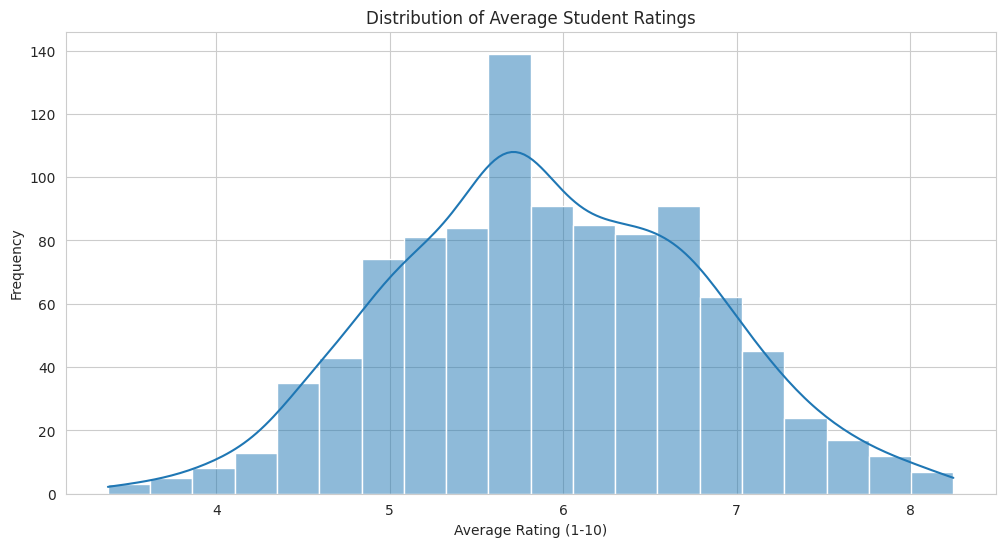

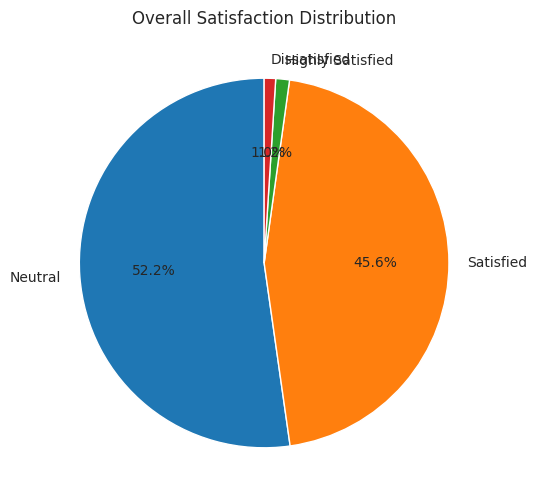

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Distribution of average ratings
plt.figure()
sns.histplot(df['Average_Rating'], bins=20, kde=True)
plt.title('Distribution of Average Student Ratings')
plt.xlabel('Average Rating (1-10)')
plt.ylabel('Frequency')
plt.show()

# 2. Satisfaction level pie chart
plt.figure()
satisfaction_counts = df['Satisfaction_Level'].value_counts()
plt.pie(satisfaction_counts, labels=satisfaction_counts.index,
        autopct='%1.1f%%', startangle=90)
plt.title('Overall Satisfaction Distribution')
plt.show()

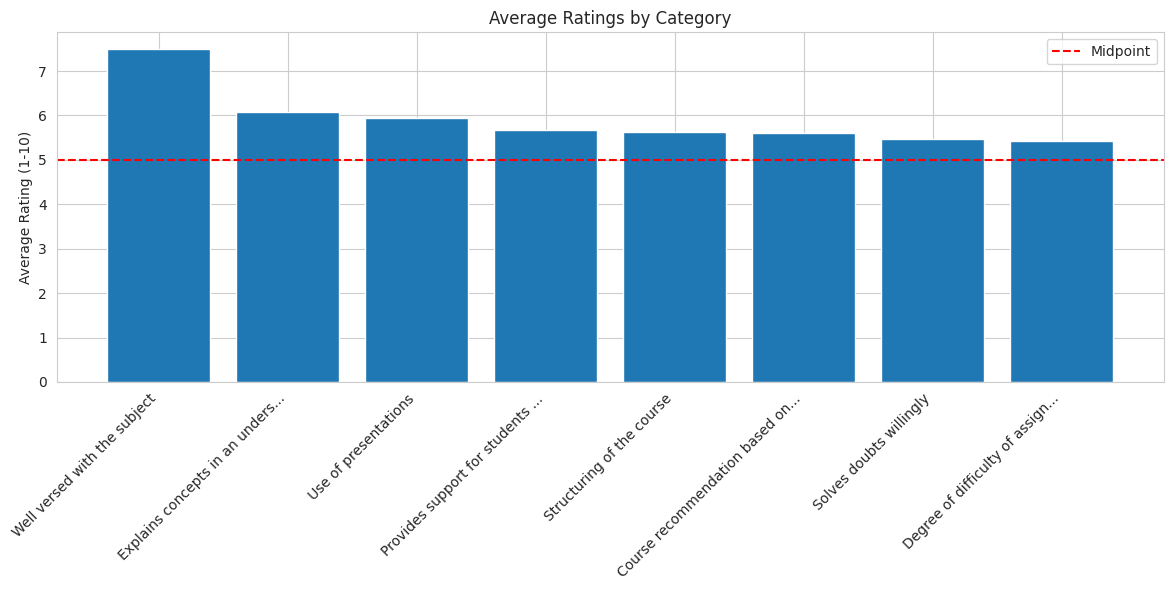

In [ ]:
# Bar chart comparing all categories
category_means = df[rating_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(category_means)), category_means.values)
plt.xticks(range(len(category_means)),
           [col[:30] + '...' if len(col) > 30 else col
            for col in category_means.index],
           rotation=45, ha='right')
plt.ylabel('Average Rating (1-10)')
plt.title('Average Ratings by Category')
plt.axhline(y=5, color='r', linestyle='--', label='Midpoint')
plt.legend()
plt.tight_layout()
plt.show()

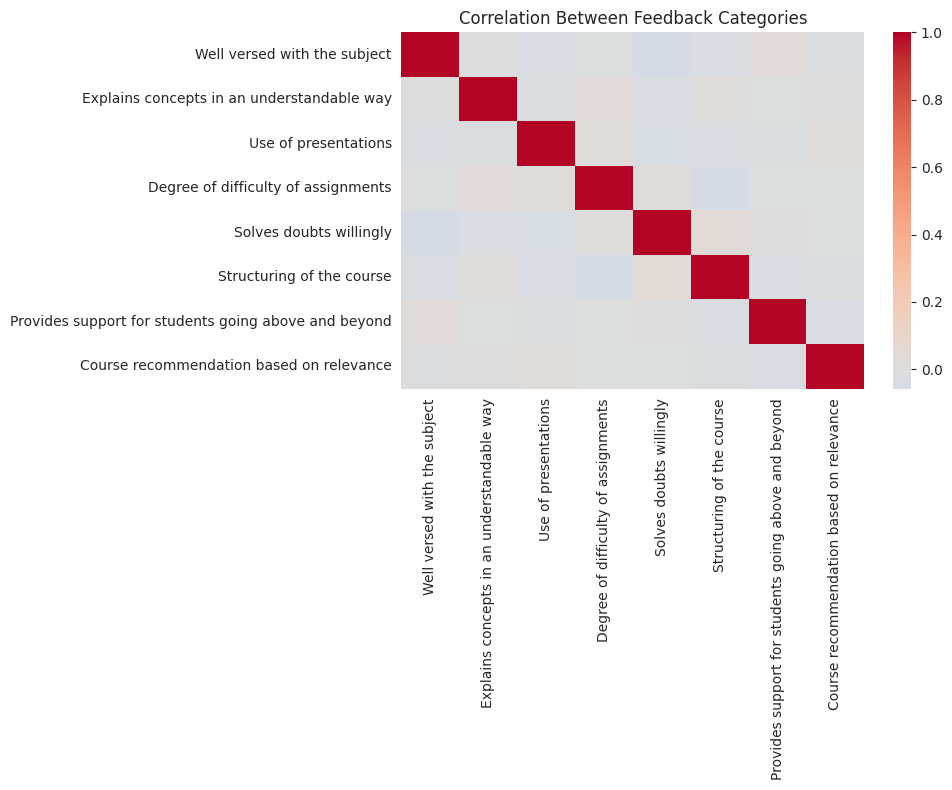

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[rating_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Between Feedback Categories')
plt.tight_layout()
plt.show()

In [ ]:
# Generate synthetic text feedback based on ratings
def generate_feedback(row):
    avg_rating = row['Average_Rating']

    if avg_rating >= 8:
        templates = [
            "Excellent course! The instructor was very knowledgeable and engaging.",
            "Great experience overall. Learned a lot and would recommend.",
            "Outstanding teaching quality and course structure."
        ]
    elif avg_rating >= 6:
        templates = [
            "Good course but could use some improvements in presentation.",
            "Decent experience. Some aspects were better than others.",
            "Satisfactory overall, though assignments were challenging."
        ]
    elif avg_rating >= 4:
        templates = [
            "Course was okay but lacked clear structure.",
            "Mixed feelings. Some parts were good, others not so much.",
            "Average experience with room for improvement."
        ]
    else:
        templates = [
            "Disappointed with the course structure and delivery.",
            "Needs significant improvement in multiple areas.",
            "Did not meet expectations. Poor organization."
        ]

    return np.random.choice(templates)

df['Text_Feedback'] = df.apply(generate_feedback, axis=1)

In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity

    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Text_Feedback'].apply(get_sentiment)
df['Polarity_Score'] = df['Text_Feedback'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

print(df['Sentiment'].value_counts())

Sentiment
Positive    811
Negative    190
Name: count, dtype: int64


In [ ]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']

    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['VADER_Sentiment'] = df['Text_Feedback'].apply(get_vader_sentiment)
df['VADER_Compound'] = df['Text_Feedback'].apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)

# Compare both methods
comparison = pd.crosstab(df['Sentiment'], df['VADER_Sentiment'])
print(comparison)

VADER_Sentiment  Negative  Positive
Sentiment                          
Negative                5       185
Positive                0       811


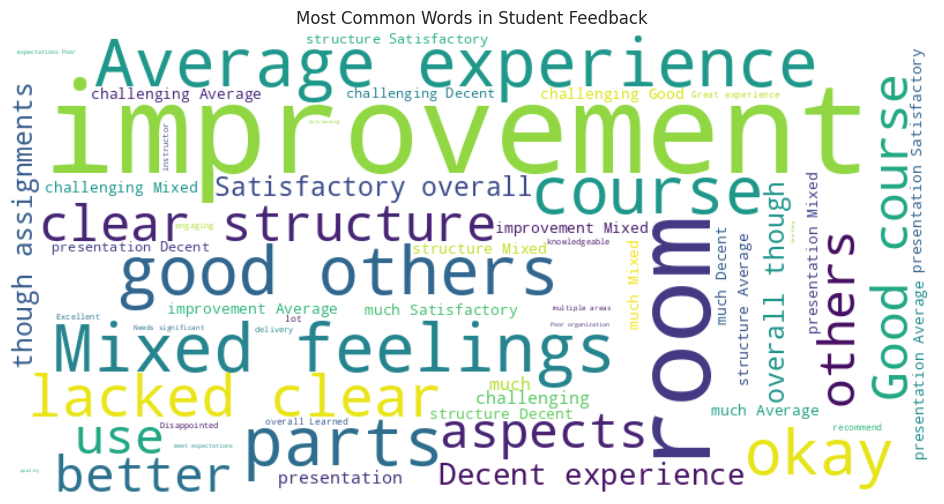

In [ ]:
from wordcloud import WordCloud

# Combine all feedback text
all_text = ' '.join(df['Text_Feedback'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='viridis').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Student Feedback')
plt.show()

          Average_Rating                 Polarity_Score
                    mean       std count           mean
Sentiment                                              
Negative        5.212500  0.551566   190      -0.168421
Positive        6.080148  0.879931   811       0.375067


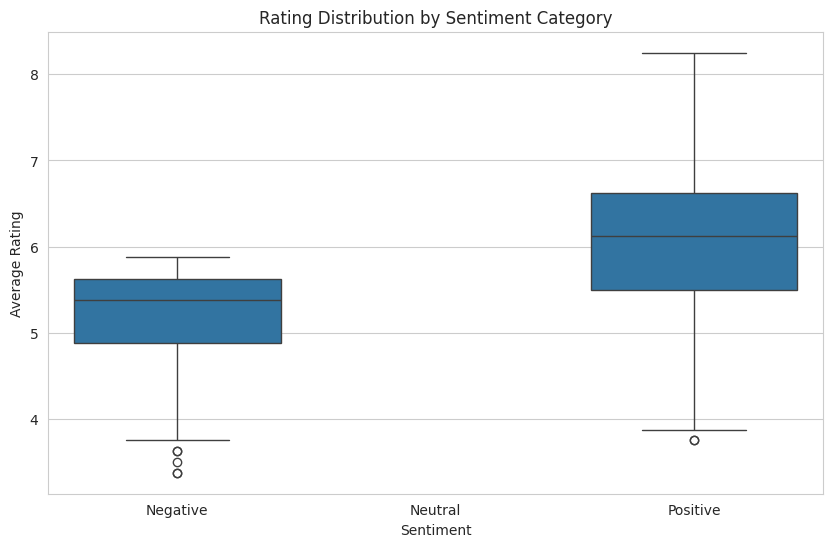

In [ ]:
# Compare numerical ratings with sentiment scores
sentiment_rating_comparison = df.groupby('Sentiment').agg({
    'Average_Rating': ['mean', 'std', 'count'],
    'Polarity_Score': 'mean'
})
print(sentiment_rating_comparison)

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Sentiment', y='Average_Rating',
            order=['Negative', 'Neutral', 'Positive'])
plt.title('Rating Distribution by Sentiment Category')
plt.ylabel('Average Rating')
plt.show()

In [ ]:
# Find lowest-rated categories
lowest_categories = df[rating_cols].mean().nsmallest(3)
print("Areas needing most improvement:")
print(lowest_categories)

# Analyze negative feedback patterns
negative_feedback = df[df['Sentiment'] == 'Negative']
print(f"\nNegative feedback count: {len(negative_feedback)}")
print("\nAverage ratings in negative feedback:")
print(negative_feedback[rating_cols].mean())

Areas needing most improvement:
Degree of difficulty of assignments         5.430569
Solves doubts willingly                     5.474525
Course recommendation based on relevance    5.598402
dtype: float64

Negative feedback count: 190

Average ratings in negative feedback:
Well versed with the subject                            7.115789
Explains concepts in an understandable way              5.389474
Use of presentations                                    5.826316
Degree of difficulty of assignments                     4.700000
Solves doubts willingly                                 4.515789
Structuring of the course                               4.747368
Provides support for students going above and beyond    4.815789
Course recommendation based on relevance                4.589474
dtype: float64


In [ ]:
# Generate comprehensive statistics
summary_stats = {
    'Total Responses': len(df),
    'Average Overall Rating': df['Average_Rating'].mean(),
    'Satisfaction Rate': (df['Average_Rating'] >= 6).sum() / len(df) * 100,
    'Positive Sentiment %': (df['Sentiment'] == 'Positive').sum() / len(df) * 100,
    'Top Rated Aspect': df[rating_cols].mean().idxmax(),
    'Lowest Rated Aspect': df[rating_cols].mean().idxmin()
}

for key, value in summary_stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

Total Responses: 1001
Average Overall Rating: 5.92
Satisfaction Rate: 46.75
Positive Sentiment %: 81.02
Top Rated Aspect: Well versed with the subject
Lowest Rated Aspect: Degree of difficulty of assignments
